# Introduction

    In this notebook, we consider the geometry of the approximants to the Ammann-Beenker tiling, and we investigate the phason shifts that occur when the window is moved in the internal space.

In [6]:
import sys
sys.path.insert(0, '../Tilings') # prepend the path to the Tiling package

import Tilings as tl
import QuantumGraph as QGraph

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.path import Path
import matplotlib.patches as patches

import networkx as nx

import scipy.linalg
from scipy.sparse.linalg import eigsh

import itertools

# interactivity in the notebook
from ipywidgets import interact, interactive
from IPython.display import clear_output, display, HTML

# replace by %matplotlib notebook for full interactivity (but beware of the flickering!)
%matplotlib inline

# The approximants in the internal space

We introduce the octonacci numbers $O_{n+1} = 2 O_{n} + O_{n-1}$, $O_0 = 0$, $O_1 = 1$.

## The selection window
The selection window is an (irregular) octagon, whose 8 vertices are given by $$\frac{1}{N^{(n)}} (\pm O_n, \pm O_{n+1})$$ or $$\frac{1}{N^{(n)}}(\pm O_{n+1}, \pm O_{n}),$$
where $N^{(n)} = \sqrt{8 O_n^2 + 2(-1)^n}$.

Alternatively, it can be described as the intersection of two squares centered about the origin, one with an horizontal base of length
$$ \boxed{L_h = 2 \frac{O_{n+1}}{N^{(n)}}} $$
and one with a base rotated by $\pi/4$, and of length
$$ \boxed{L_d = \sqrt{2}\frac{O_n + O_{n+1}}{N^{(n)}}} $$

## Tiling the internal space
In perpendicular space, the points of the $\mathbb{Z}^4$ tiling form a **square tiling** whose lattice parameters are: 
\begin{align}
a^{(n)} & = (-1,1)/N^{(n)} \\
b^{(n)} & = (1,1)/N^{(n)}
\end{align}

Since the lattice vectors have length $\sqrt{2}/N^{(n)}$, we see that the number of lattice points in a $\pi/4$ diagonal of the window is
$$ \boxed{n_d = O_{n}+O_{n+1}} $$
while the number of lattice points in an horizontal diagonal is
$$ \boxed{n_h = O_{n+1}} $$

To count the total number of lattice points inside the window $C^{(n)}$, we can divide the area of the window by the area of a unit cell. 
We obtain $ C^{(n)} = 2 O_{n+1}^2 -\left(O_{n} + O_{n-1}\right)^2 $ that is
$$ \boxed{C^{(n)} = O_{2n+1}+O_{2n}} $$

In [7]:
def o(n):
    a, b = 0, 1
    for i in range(n):
        a, b = b, a + 2*b
    return a

def norm(n):
    return np.sqrt(8.*o(n)**2+2.*(-1)**n)

def vecs(n):
    """
    return the generating vectors of the internal space lattice
    """
    return np.array([[-1.,1.],[1.,1.]])/norm(n)

def window(n):
    """
    return the eight vertices of the window
    """
    o1 = o(n)
    o2  =o(n+1)
    return np.array([[o1,o2],[-o1,o2],[-o2,o1],[-o2,-o1],[-o1,-o2],[o1,-o2],[o2,-o1],[o2,o1]])/norm(n)

def Lh(n):
    return 2*o(n+1)/norm(n)
    
def Lv(n):
    return np.sqrt(2)*(o(n)+o(n+1))/norm(n)

def vertices(n, L):
    """
    Return the tiling points in a square of size L*L
    """
    a, b = vecs(n)
    s = int(L/2)
    xrange = np.arange(-s, s)
    yrange = np.arange(-s, s)
    verts = np.array([na*a + nb*b for na, nb in itertools.product(xrange, yrange)])
    return verts

def vertices2(n, L):
    """
    Same as vertices, except they are shifted so that one vertex is at the corner of the window
    if it is centered about the origin
    """
    cn = np.array([o(n), o(n-1)])/norm(n)
    return vertices(n,L) - cn

In [8]:
def draw_window(ax, n, center):
    """
    Draw on axis ax the window of the nth approximant
    """
    verts = list(window(n) - center) + [[0,0]]

    codes = [Path.MOVETO] + [Path.LINETO for x in range(len(verts)-2)] + [Path.CLOSEPOLY]
    path = Path(verts, codes)

    patch = patches.PathPatch(path, facecolor='orange', lw=1, alpha=0.5)
    ax.add_patch(patch)
    ax.set_xlim(-1.1 - center[0],1.1 - center[0])
    ax.set_ylim(-1.1 - center[1],1.1 - center[1])
    ax.set_aspect('equal')

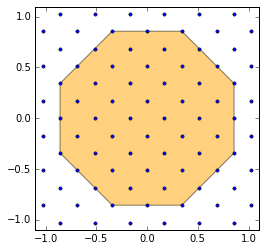

In [9]:
"""
Draw the lattice in internal space, together with the window
"""

n = 2
fig = plt.figure()

verts = vertices2(n, 30)
ax = fig.add_subplot(111)
ax.plot(*verts.T, 'o', markersize = 10**2/5.5**(n), mec=None)

draw_window(ax, n, (0,0))

ax.set_xlim(-1.1, 1.1)
ax.set_ylim(-1.1, 1.1)

plt.savefig("selection.pdf")
plt.show()

True


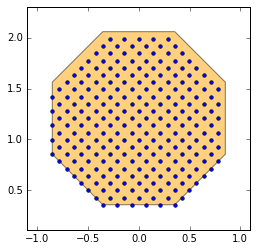

In [10]:
"""
Draw directly the vertices that are inside of the window
"""

# order of the approximant
n = 3
# vectors of the lattice in internal space
a, b = vecs(n)

def vtest_canonical(n, i, j):
    """
    Return True if the point i*a+j*b is inside the window of the nth approximant
    """
    return i-j <= o(n+1) and -i+j < o(n+1) and i+j >= o(n) and i+j < 2*o(n+1)+o(n)

def vtest(n, i, j):
    """
    Return True if the point i*a+j*b is inside the window of the nth approximant
    """
    return i-j <= o(n+1) and -i+j <= o(n+1)-1 and i+j >= o(n) and i+j <= 2*o(n+1)+o(n)-1

# number of lattice points in a diagonal at pi/4 of the octagon
nd = o(n)+o(n+1) 
# vertices of the the nth approximant
verts = np.array([i*a+j*b for i in range(nd) for j in range(nd) if vtest(n, i, j)])
# check if we have the correct number of vertices
print(len(verts) == o(2*n) + o(2*n+1)) 
# translation vector by which to translate the window origin to place it in singular position
tvec = (0,-(o(n)+o(n+1))/norm(n))

# plot
fig = plt.figure()
ax = fig.add_subplot(111)
draw_window(ax, n, tvec)
ax.plot(*verts.T, 'o', markersize = 10**2/3**(n), mec=None)
plt.savefig("test.pdf")

# The approximants in the physical space

The projection matrix onto the internal space is
$$
P_{\perp}^{(n)} = 
\frac{1}{N^{(n)}}
\begin{bmatrix}
    2 O_n & -O_n-O_{n-1} & 0 & O_n+O_{n+1}\\
	0 & O_n+O_{n+1} & -2 O_n & O_n+O_{n+1}\\
\end{bmatrix}
$$

To build the approximants in physical space, we use the inflation method. We check that in internal space, this produces the sames lattices points

In [20]:
e = np.identity(4) # base of the Z4 lattice

def square(orig, ea, eb):
    """
    create a square with edges along ea and eb
    the arrows of the square are directed by ea and eb
    """
    if not np.isclose(np.vdot(ea, eb).real, 0, atol = 1e-10):
        raise RuntimeError("The specified edges cannot be used to create a square " + str(np.vdot(ea, eb).real))
    
    B = orig
    A = orig + ea
    C = orig + ea + eb
    t1 = (1, (A, B, C))
    
    A = orig + eb
    t2 = (1, (A, B, C))
    
    return [t1, t2]

def plotp(pgraph, s, lims = None):
    """
    plot what happens in the internal space
    """
    dict_pos = nx.get_node_attributes(pgraph, 'perp')
    plt.axes().set_aspect('equal')
    
    if lims:
        plt.xlim(lims[0])
        plt.ylim(lims[1])
    
    nx.draw_networkx(pgraph, dict_pos, with_labels = False, node_size= s, width = 1)      
    plt.savefig("perp.pdf")
    plt.show()

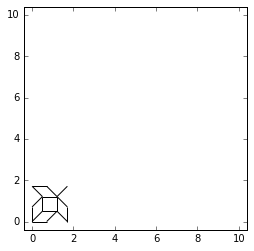

In [100]:
n = 1 # number of inflations

# create a tiling whose basic tile is a square
sq = tl.A5(square(np.zeros(4),e[0],e[2]))
sq.it_sub(n)

"""
The tiling in physical space
"""
plt.close() # close any previous plot
l = -.4
L = 10.4
QGraph.plot(sq._graph, lims=((l,L),(l,L)), weights = 1)

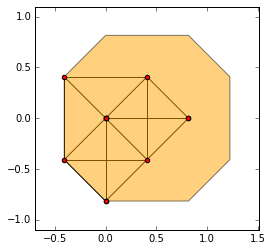

In [101]:
"""
The tiling in internal space
"""

plt.close() # close any previous plot

def center(n):
    """ return the vector by which to translate the window to place it in singular position """
    a, b = vecs(n)
    return ((-1)**(n+1)*a-b)/2.

draw_window(plt.axes(), n, center(n))
plotp(sq._graph, 20)

In [27]:
sq = tl.A5(square(np.zeros(4),e[0],e[2]))

def plot_graph(n):
    # inflate n times
    sq.it_sub(n)
    sq.plot_graph()
    
    return sq._graph

In [28]:
w = interactive(plot_graph, n=(0,5))
display(w)

In [29]:
def plot_perp(n, node_size, x, y):
    draw_window(plt.axes(), n, (x,y))
    sq.it_sub(n)
    plotp(sq._graph, node_size)

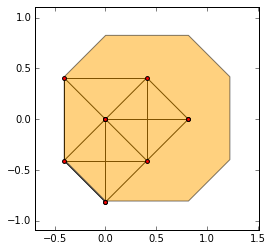

In [30]:
w = interactive(plot_perp, n={"1":1,"2":2,"3":3}, node_size=(0,30,.001), x=(-.5,.5,.01), y=(-.5,.5,.01))
display(w)

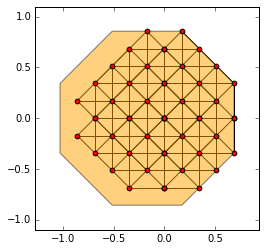

In [31]:
plot_perp(2, 22, 0.17, 0.)

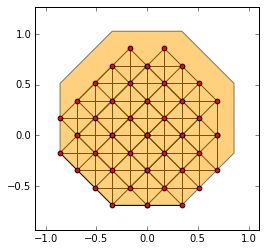

In [13]:
plot_perp(2, 22, 0., -0.17)

In [14]:
o(3)+o(2)

7

In [8]:
g = QGraph.periodize(sq._graph)

def rotation(theta):
    """
    Return 2D rotation matrix of angle theta
    """
    return np.array([[np.cos(theta), -np.sin(theta)], 
                         [np.sin(theta),  np.cos(theta)]])

def edges(g, theta):
    """
    Return the extreme points of g lying in direction theta (wrt to horizontal) and in the orthogonal direction
    """
    # get the positions of the nodes
    pos = np.asarray(list(nx.get_node_attributes(g, 'perp').values()))
    # rotate
    rot_mat = rotation(-theta) # rotating the points by -theta amounts to rotating the axes by theta
    pos = np.dot(rot_mat, pos.T).T
    # find the extreme points
    x, y = zip(*pos)
    xmin = min(x) # leftmost abscissa
    xmax = max(x) # rightmost abscissa
    ymin = min(y) # bottommost ordinate
    ymax = max(y) # topmost ordinate
    
    # tolerance is one percent of the average distance between two nodes
    av_dist = min(xmax-xmin, ymax-ymin)/np.sqrt(len(x))    
    tol = 0.01*av_dist

    left_nodes = []
    right_nodes = []
    top_nodes = []
    bottom_nodes = []

    for p in g.nodes(data=True):
        px, py = np.dot(rot_mat, p[1]['perp'])
        if np.isclose(px, xmin, atol=tol):
            left_nodes.append(p[0])
        elif np.isclose(px, xmax, atol=tol):
             right_nodes.append(p[0])

        if np.isclose(py, ymin, atol=tol):
            bottom_nodes.append(p[0])
        elif np.isclose(py, ymax, atol=tol):
            top_nodes.append(p[0])
            
    return ((left_nodes, right_nodes), (bottom_nodes, top_nodes))

def window_center(tl):
    """
    Return the point the window should have as a center for the tiling to be in a canonical position
    """
    g = QGraph.periodize(tl._graph)
    n = tl._ninf
    ((left_nodes, right_nodes), (bottom_nodes, top_nodes)) = edges(g, 0.)

    ev = int(len(right_nodes) < len(left_nodes))
    Eh = int(len(bottom_nodes) < len(top_nodes))

    o0 = o(n)
    o1 = o(n+1)
    V = np.array([[[-o1,-o0],[-o1,o0]],[[o1,-o0],[o1,o0]]])/norm(n)

    if ev:
        refedge = right_nodes
    else:
        refedge = left_nodes
    # dict to perp
    perppos = nx.get_node_attributes(tl._graph, 'perp')
    if Eh:
        refpt = max(refedge, key=lambda p:perppos[p][1])
    else:
        refpt = min(refedge, key=lambda p:perppos[p][1])
    
    return V[ev,Eh] - perppos[refpt]


In [10]:
n = 3
sq = tl.A5(square(np.zeros(4),e[0],e[2]))
sq.it_sub(n)

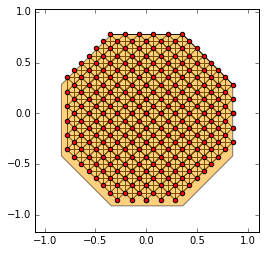

In [11]:
draw_window(plt.axes(), n, window_center(sq))
plotp(sq._graph, 20)

In [9]:
def singular_nodes_periodized(g):
    """
    Return the singular nodes (ie nodes about to jump), grouped by edge of the window.
    For this function to work, the graph has to be periodized (otherwise the counting is not correct).
    """
    # horizontal and vertical edge nodes
    h, v = edges(g, 0.)
    # first and second bisector edge nodes
    b1, b2 = edges(g, np.pi/4.)
    
    lh = [len(s) for s in h]
    lv = [len(s) for s in v]
    lb1 = [len(s) for s in b1]
    lb2 = [len(s) for s in b2]
    
    # add the horizontal and vertical singular edges
    right = int(lh[0] > lh[1]) # if True the right edge h[1] is added
    top = int(lv[0] < lv[1]) # if True the top edge v[1] is added

    horizontal = h[right]
    vertical = v[top]
    
    # add the diagonal singular edges
    if (right and top) or (not right and not top):
        test = int(lb2[0] > lb2[1])
        bisec2 = b2[test]
        if right and top:
            bisec1 = b1[1]
        else:
            bisec1 = b1[0]
    else:
        test = int(lb1[0] > lb1[1])
        bisec1 = b1[test]
        if not right and top:
            bisec2 = b2[1]
        else:
            bisec2 = b2[0]
            
    # return the sides in trigonometrical order 
    return (horizontal, bisec1, vertical, bisec2)


In [10]:
def singular_nodes(tiling):
    """
    Return the singular nodes of the tiling, based on the observation 
    that singular nodes can be chosen as right, b1+, top, b2+ if the number of inflations n is odd,
    and they can be chosen as left, b1-, bottom, b2- if n is even.
    """
    
    # horizontal and vertical edge nodes
    h, v = edges(tiling._graph, 0.)
    # first and second bisector edge nodes
    b1, b2 = edges(tiling._graph, np.pi/4.)
    
    n = tiling._ninf
    idx = n%2
    return (h[idx], b1[idx], v[idx], b2[idx])

In [38]:
n = 3
sq = tl.A5(square(np.zeros(4),e[0],e[2]))
sq.it_sub(n)

cn = singular_nodes(sq)

# pass from nodes to their perpendicular position
perppos = nx.get_node_attributes(sq._graph, 'perp')
cn = [np.array([perppos[p] for p in s]) for s in cn]

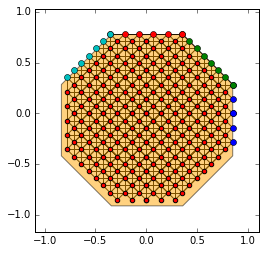

In [39]:
draw_window(plt.axes(), n, window_center(sq))
for s in cn:plt.plot(*(s.T), 'o')
plotp(sq._graph, 20)

# Phason jumps

Now that we have listed the singular sites, we can perform phasonic jumps. 
Since the singular sites lie on 4 *consecutive* sides of the window, we can either 
* make a single side jump (this would be 1 of the the two external sides)
* make 3 sides jump (this would be the 2 internal sides plus one external side).

Moreover, the 3 side jumps can be decomposed as a succession of 3 single-side jumps.
So, let us start with single side jumps.

In [286]:
n = 3
sq = tl.A5(square(np.zeros(4),e[0],e[2]))
sq.it_sub(n)

#pg = QGraph.periodize(sq._graph)
pg = sq._graph.copy()
cn = singular_nodes(sq)
# for n=3, cn1 are the singular nodes along the right edge of the window
cn1 = cn[0]
# basis
e = np.identity(4)
def to_left_jump(p):
    # take a node along the right edge, return a node along the left edge
    return p-e[3]-e[0]+e[1]
def left_neigh(new_p):
    # return the new neighbors of the jumped node
    neighs = (new_p+e[3],new_p+e[0],new_p-e[1])
    # convert to tuples
    neighs = list(map(tuple, neighs))
    return neighs

# compute the jumps
jumped_nodes = [tuple(to_left_jump(p)) for p in cn1]
# compute the para and perp projections of the jumped nodes
P = sq.para()
Pi = sq.perp_proj()
jumped_nodes_data = [(n, dict(para=np.dot(P, n), perp=np.dot(Pi, n))) for n in jumped_nodes]
# remove the old nodes
pg.remove_nodes_from(cn1)
# add the new nodes
pg.add_nodes_from(jumped_nodes_data)
# compute the new neighbors
jumped_edges = [(new, neigh) for new in jumped_nodes for neigh in left_neigh(new) if neigh in pg.nodes()]
pg.add_edges_from(jumped_edges)


In [287]:
perppts = np.array([np.dot(Pi,n) for n in jumped_nodes])
crits = np.array([np.dot(Pi,n) for n in cn1])

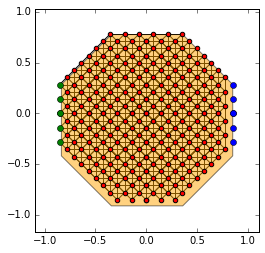

In [288]:
draw_window(plt.axes(), n, window_center(sq))
plt.plot(*(crits.T), 'o')
plt.plot(*(perppts.T), 'o')
plotp(pg, 20)

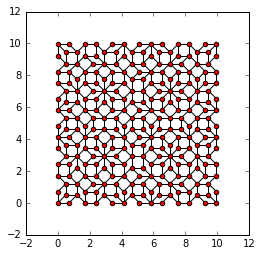

In [291]:
QGraph.plot(sq._graph, lims=((-2,12),(-2,12)), weights=1, s=20, savename="p1")
plt.close()
QGraph.plot(pg, lims=((-2,12),(-2,12)), weights=1, s=20, savename="p2")

We wrap the different steps inside a function, which, given a graph, the list of singular nodes, and a singular direction to jump,
* Performs the jump ie modifies the graph to take the jump into account
* Modifies the list of singular nodes accordingly

Note that:
* singular_nodes is a dict whose keys are integers in range(8) labelling the window edges, and whose values are the singular nodes along the corresponding edge (or None if the edge is not singular).
* jumping_edge is an integer coding for the desired singular edge to jump.
The window edges are conventionaly labelled starting from the top one, and going around the octagon clockwise.

In [32]:
def rotation(theta):
    """
    Return 2D rotation matrix of angle theta
    """
    return np.array([[np.cos(theta), -np.sin(theta)], 
                         [np.sin(theta),  np.cos(theta)]])

def edge_nodes(g, theta):
    """
    Return the extreme points of g lying in direction theta (wrt to horizontal) and in the orthogonal direction
    """
    # get the positions of the nodes
    pos = np.asarray(list(nx.get_node_attributes(g, 'perp').values()))
    # rotate
    rot_mat = rotation(-theta) # rotating the points by -theta amounts to rotating the axes by theta
    pos = np.dot(rot_mat, pos.T).T
    # find the extreme points
    x, y = zip(*pos)
    xmin = min(x) # leftmost abscissa
    xmax = max(x) # rightmost abscissa
    ymin = min(y) # bottommost ordinate
    ymax = max(y) # topmost ordinate
    
    # tolerance is one percent of the average distance between two nodes
    av_dist = min(xmax-xmin, ymax-ymin)/np.sqrt(len(x))    
    tol = 0.01*av_dist

    left_nodes = []
    right_nodes = []
    top_nodes = []
    bottom_nodes = []

    for p in g.nodes(data=True):
        px, py = np.dot(rot_mat, p[1]['perp'])
        if np.isclose(px, xmin, atol=tol):
            left_nodes.append(p[0])
        elif np.isclose(px, xmax, atol=tol):
             right_nodes.append(p[0])

        if np.isclose(py, ymin, atol=tol):
            bottom_nodes.append(p[0])
        elif np.isclose(py, ymax, atol=tol):
            top_nodes.append(p[0])
            
    return ((left_nodes, right_nodes), (bottom_nodes, top_nodes))

In [226]:
class Edge:
    """
    A class storing informations about an edge of the window of an AB tiling.
    """
    # basis of Z4
    e = np.identity(4)
    # list of the vectors directing the egdes (going counterclockwise around the window)
    edge_list = [-e[2], e[1], -e[0], -e[3], e[2], -e[1], e[0], e[3]]
    # convert to tuples
    edge_list = list(map(tuple, Edge.edge_list))
    # get the position of a vector in the list
    edge_idx = {ed:idx for ed, idx in zip(Edge.edge_list, range(8))}
    axes = ["h", "b1", "v", "b2"]
    edge_ax = {Edge.edge_list[i]:Edge.axes[i%4] for i in range(8)}
    
    def __init__(self, vector, nodes = None):
        # the vector of the Z4 base directing the edge (going counterclockwise around the window)
        self._v = np.array(vector)
        self._nodes = nodes
        self._ax = self.edge_ax[tuple(self._v)]
        
    def to_opposite(self):
        """
        return the 3 vectors connecting self to the opposite Edge
        """
        idx = self.edge_idx[tuple(self._v)]
        return [self.edge_list[i % 8] for i in range(idx+1, idx+4)]
    
class Window:
    """
    A class storing informations about the window of an AB tiling.
    """
    
    def __init__(self, tl):
        # tiling
        self._tl = tl
        # add a "singular" attribute to the singular nodes
        sing_nodes_list = self.singular_nodes()
        labels = ["h", "b1", "v", "b2"]
        for sing_nodes, label in zip(sing_nodes_list, labels):
            for node in sing_nodes:
                try:
                    dat = self._tl._graph.node[node]["singular"]
                    dat += (label,)
                except KeyError:
                    dat = (label,)
                self._tl._graph.node[node]["singular"] = dat
        # record the initial position of the window center
        self._w0 = window_center(self._tl)
        
    def singular_nodes(self):
        """
        Return the singular nodes of the tiling, based on the observation 
        that singular nodes can be chosen as right, b1+, top, b2+ if the number of inflations n is odd,
        and they can be chosen as left, b1-, bottom, b2- if n is even.
        """

        # horizontal and vertical edge nodes
        h, v = edge_nodes(self._tl._graph, 0.)
        # first and second bisector edge nodes
        b1, b2 = edge_nodes(self._tl._graph, np.pi/4.)

        n = self._tl._ninf
        idx = n%2
        return (h[idx], b1[idx], v[idx], b2[idx])
    
    def jump(self, vec):
        # retrieve the corresponding edge
        edge = Edge(vec)
        # perform the jump
        new_nodes = self._update_graph(edge)
    
    def _transfer_nodes(self, old, new):
        """
        remove old nodes, add new nodes, with their projections and the new axe value
        """
        # compute the para and perp projections of the jumped nodes
        P = self._tl.para()
        Pi = self._tl.perp_proj()
        # retrieve the old singular data (it is the same for all old nodes)
        ax = self._tl._graph.node[old[0]]['singular']
        # construct the list of new node with their data
        new_with_data = [(n, {'para':np.dot(P, n), 'perp':np.dot(Pi, n), 'singular':ax}) for n in new]
        # remove the old nodes
        self._tl._graph.remove_nodes_from(old)
        # add the new nodes
        self._tl._graph.add_nodes_from(new_with_data)
    
    def _update_graph(self, edge):
        """
        update the tiling graph so that nodes along the criticial edge are jumped to the opposite edge
        return the new (jumped) nodes
        """
        axis = edge._ax
        # singular nodes
        sing_nodes = nx.get_node_attributes(self._tl._graph, 'singular')
        # singular nodes along the given edge
        sing_nodes = [node for node in sing_nodes if axis in sing_nodes[node]]
        # retrieve the translation vectors connecting edge to the opposite one
        a, b, c = edge.to_opposite()
        transl = lambda p: np.array(p) + a + b + c
        # compute the new (jumped) nodes
        jumped_nodes = [tuple(transl(p)) for p in sing_nodes]
        self._transfer_nodes(sing_nodes, jumped_nodes)
        def neighbors(p):
            """
            return the neighbors of the jumped node new_p
            """
            p = np.array(p)
            neighs = (p-a,p-b,p-c)
            # convert to tuples
            neighs = list(map(tuple, neighs))
            return neighs
        # compute the new neighbors
        jumped_edges = [(new, neigh) for new in jumped_nodes for neigh in neighbors(new) if neigh in self._tl._graph.nodes()]
        # add the jumped sites and link them to their neighbors
        self._tl._graph.add_edges_from(jumped_edges)
        
        return jumped_nodes
    
    def plot(self):
        sing_nodes = list(nx.get_node_attributes(self._tl._graph, 'singular').keys())
        Pi = self._tl.perp_proj()
        perppts = np.array([np.dot(Pi,n)for n in sing_nodes])
        draw_window(plt.axes(), n, self._w0)
        plt.plot(*(perppts.T), 'o')
        plotp(self._tl._graph, 20)
    

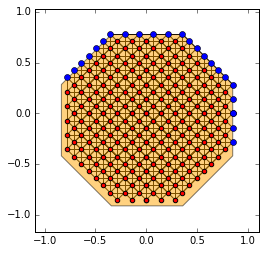

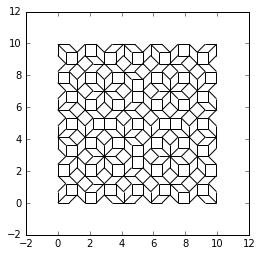

In [283]:
n = 3
sq = tl.A5(square(np.zeros(4),e[0],e[2]))
sq.it_sub(n)

w = Window(sq)
w.plot()
sq.plot_graph()

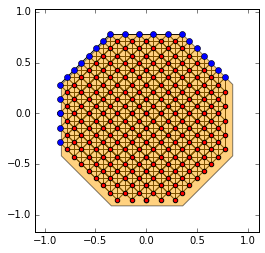

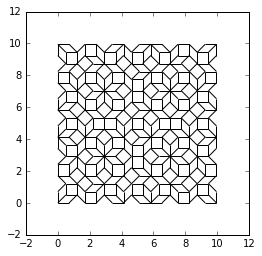

In [284]:
w.jump(-e[2])
w.plot()
sq.plot_graph()